## Entregable - Personal

**Nombre:** MELISSA QUISPE BALDEON

El notebook es sobre la clasificación de imágenes de gatos y perros usando las Redes Neuronales Convolucionales (CNN).

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications import VGG16
# from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import backend as K
# from vis.utils import utils
from keras import activations
# from vis.visualization import visualize_activation, get_num_filters
# from vis.input_modifiers import Jitter

# Funcionde de utilidad

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])  # Cambiar 'acc' por 'accuracy'
    acc = smooth_curve(history.history['accuracy'][:steps])  # Cambiar 'acc' por 'accuracy'
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])  # Cambiar 'val_acc' por 'val_accuracy'
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    epochs = range(1, steps + 1)

    plt.figure(figsize=(12, 9))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure(figsize=(12, 9))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# Construyendo una red neuronal convolucional

## Definicion del modelo

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Data Generator

In [ ]:
%%capture
!pip install kaggle

In [ ]:
import os

# Reemplaza con tu nombre de usuario y API key
kaggle_username = 'melissaquispebaldeon'
kaggle_key = 'eb60cd51bdf94537db2c86766b10ec11'

# Configura las variables de entorno para Kaggle
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key


In [ ]:
!kaggle datasets list


ref                                                                  title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                         Student Performance Predictions                  9KB  2024-08-17 06:57:57           5219        115  0.9411765        
uom190346a/sleep-and-health-metrics                                  Sleep and Health Metrics                        73KB  2024-08-31 02:39:09            866         26  1.0              
berkayalan/paris-2024-olympics-medals                                Paris 2024 Olympics Medals                       1KB  2024-08-14 11:02:45           4844         90  1.0              
jeannicolasduval/2024-fortune-1000-companies                

In [ ]:
import kaggle
import os

dataset = 'jhe2918/cats-and-dogs-small'  # Formato correcto: 'username/dataset-name'

# directorio de destino
destination_dir = '/content/dataset'

# Creación del directorio si no existe
os.makedirs(destination_dir, exist_ok=True)

# Descarga del dataset completo
kaggle.api.dataset_download_files(dataset, path=destination_dir, unzip=True)

print(f'Dataset descargado y descomprimido en {destination_dir}')


Dataset URL: https://www.kaggle.com/datasets/jhe2918/cats-and-dogs-small
Dataset descargado y descomprimido en /content/dataset


In [ ]:
import tensorflow as tf


In [ ]:
import os

print(os.listdir('/content/dataset/cats_and_dogs_small'))  # Para ver el contenido de base_dir
print(os.listdir('/content/dataset/cats_and_dogs_small/train'))  # Para ver el contenido de train_dir
print(os.listdir('/content/dataset/cats_and_dogs_small/validation'))  # Para ver el contenido de validation_dir
print(os.listdir('/content/dataset/cats_and_dogs_small/test'))  # Para ver el contenido de test_dir


['validation', 'test', 'train']
['cats', 'dogs']
['cats', 'dogs']
['cats', 'dogs']


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_dir = '/content/dataset/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
print(f"Tamaño del generador de validación: {len(validation_generator)}")


Tamaño del generador de validación: 50


In [ ]:
# Obtenemos un lote de datos del generador de validación
images, labels = next(validation_generator)

print(f"Forma de las imágenes: {images.shape}")
print(f"Forma de las etiquetas: {labels.shape}")


Forma de las imágenes: (20, 150, 150, 3)
Forma de las etiquetas: (20,)


## Training

In [ ]:
# verificamos el modelo
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# generador de datos

x_batch, y_batch = next(train_generator)
print(x_batch.shape, y_batch.shape)  # uso de las dimensiones de los datos


(20, 150, 150, 3) (20,)


In [ ]:
# Para el generador de entrenamiento
num_train_images = train_generator.n  # Total de imágenes de entrenamiento
print("Total de imágenes de entrenamiento:", num_train_images)

# Para el generador de validación
num_validation_images = validation_generator.n  # Total de imágenes de validación
print("Total de imágenes de validación:", num_validation_images)


Total de imágenes de entrenamiento: 2000
Total de imágenes de validación: 1000


In [ ]:
# ajuste de parametros
steps_per_epoch = 2000 // 20
validation_steps = 800 // 20  #  el número de imágenes de validación


In [ ]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.5178 - loss: 0.8130 - val_accuracy: 0.5925 - val_loss: 0.6753
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5350 - val_loss: 0.6838
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5945 - loss: 0.6708 - val_accuracy: 0.5612 - val_loss: 0.6667
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5400 - val_loss: 0.6835
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6385 - loss: 0.6415 - val_accuracy: 0.6438 - val_loss: 0.6358
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6700 - val_loss: 0.5915
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6841 - loss: 0.5887 - val_accuracy: 0.6787 - val_loss: 0.6117
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00

In [ ]:
model.save('model.h5')
save_history(history, 'history.bin')

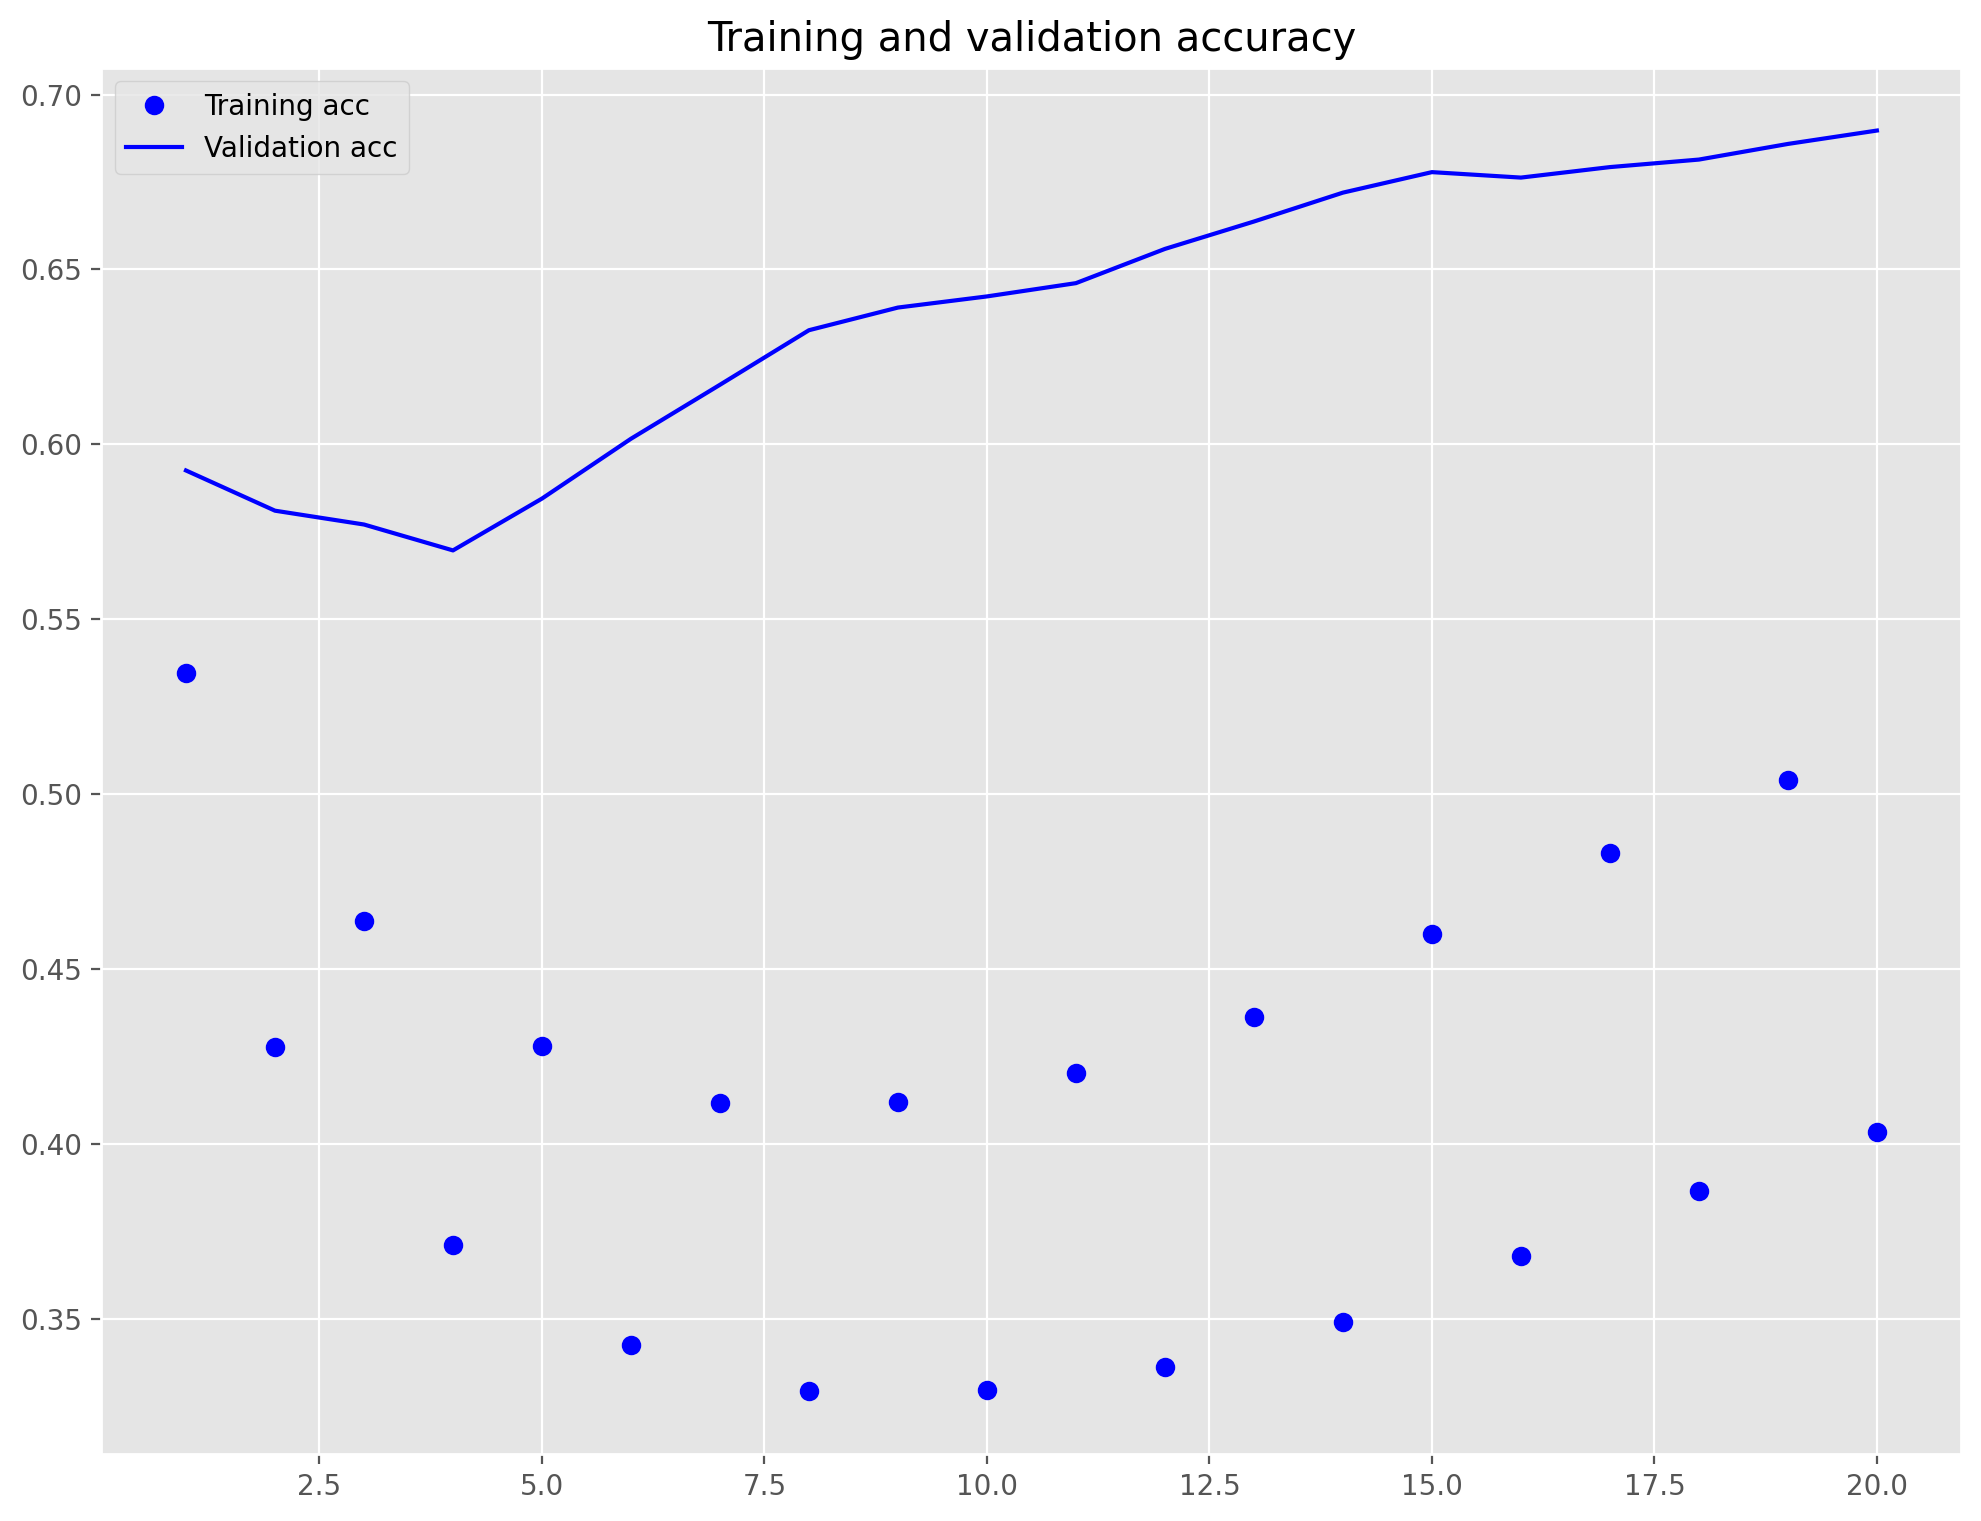

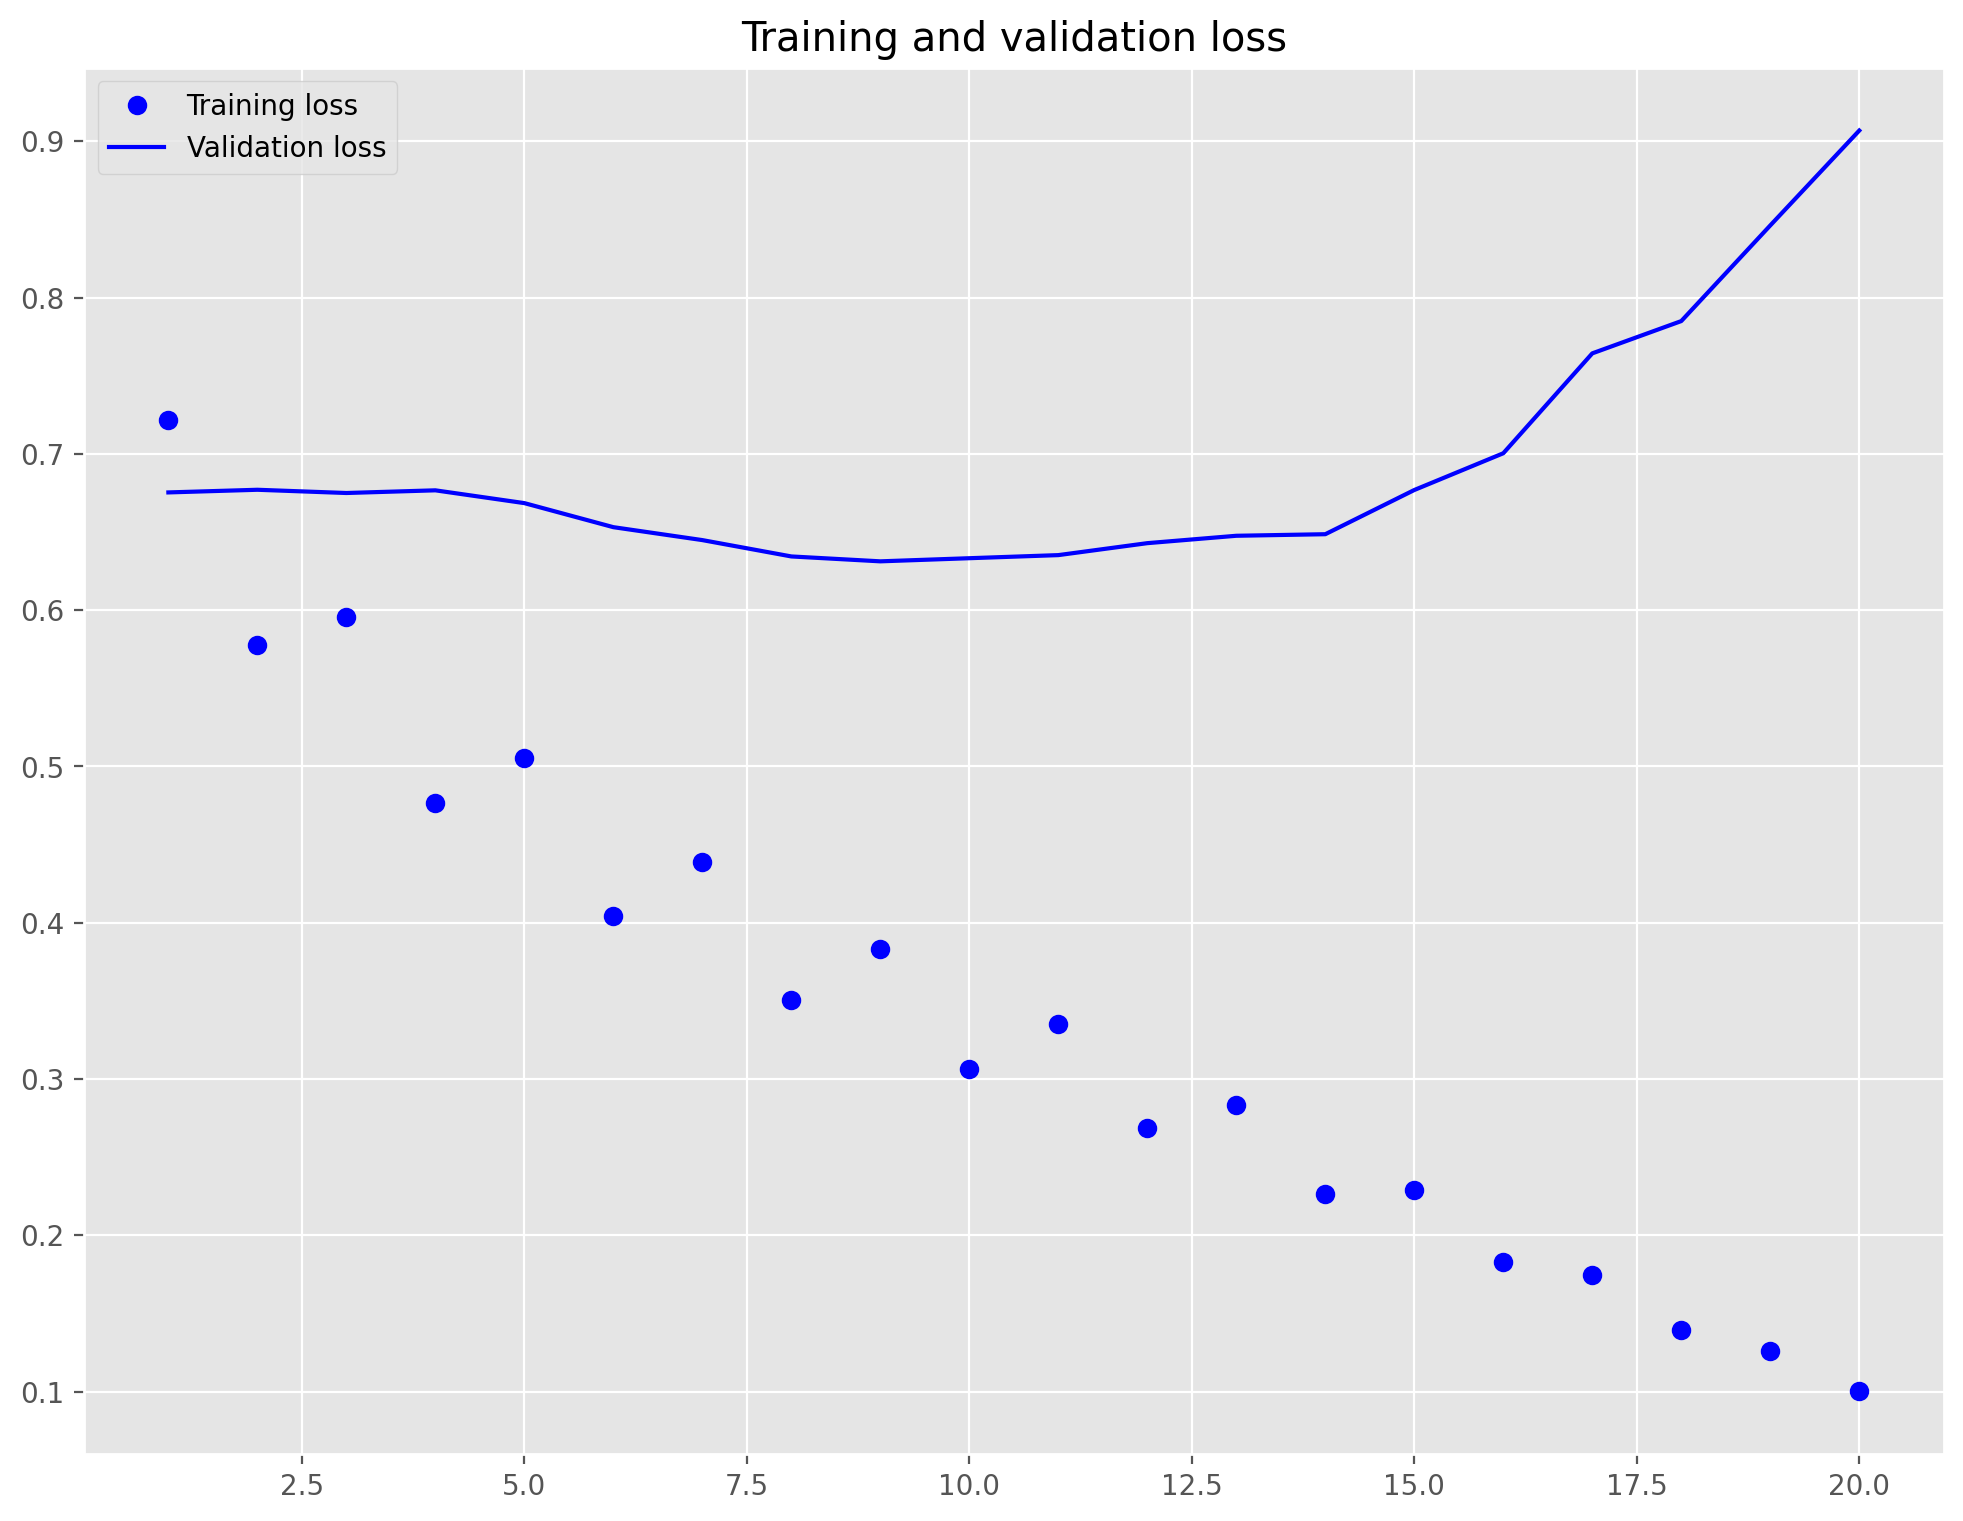

In [ ]:
history = load_history('history.bin')
plot_compare(history)

## Data Augmentation

In [ ]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(1, activation='sigmoid', name='output'))

In [ ]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history_aug = model_aug.fit(train_generator, steps_per_epoch=100, epochs=60,
                                      validation_data=validation_generator, validation_steps=50, verbose=0)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
model_aug.save('model_aug.h5')
save_history(history_aug, 'history_aug.bin')

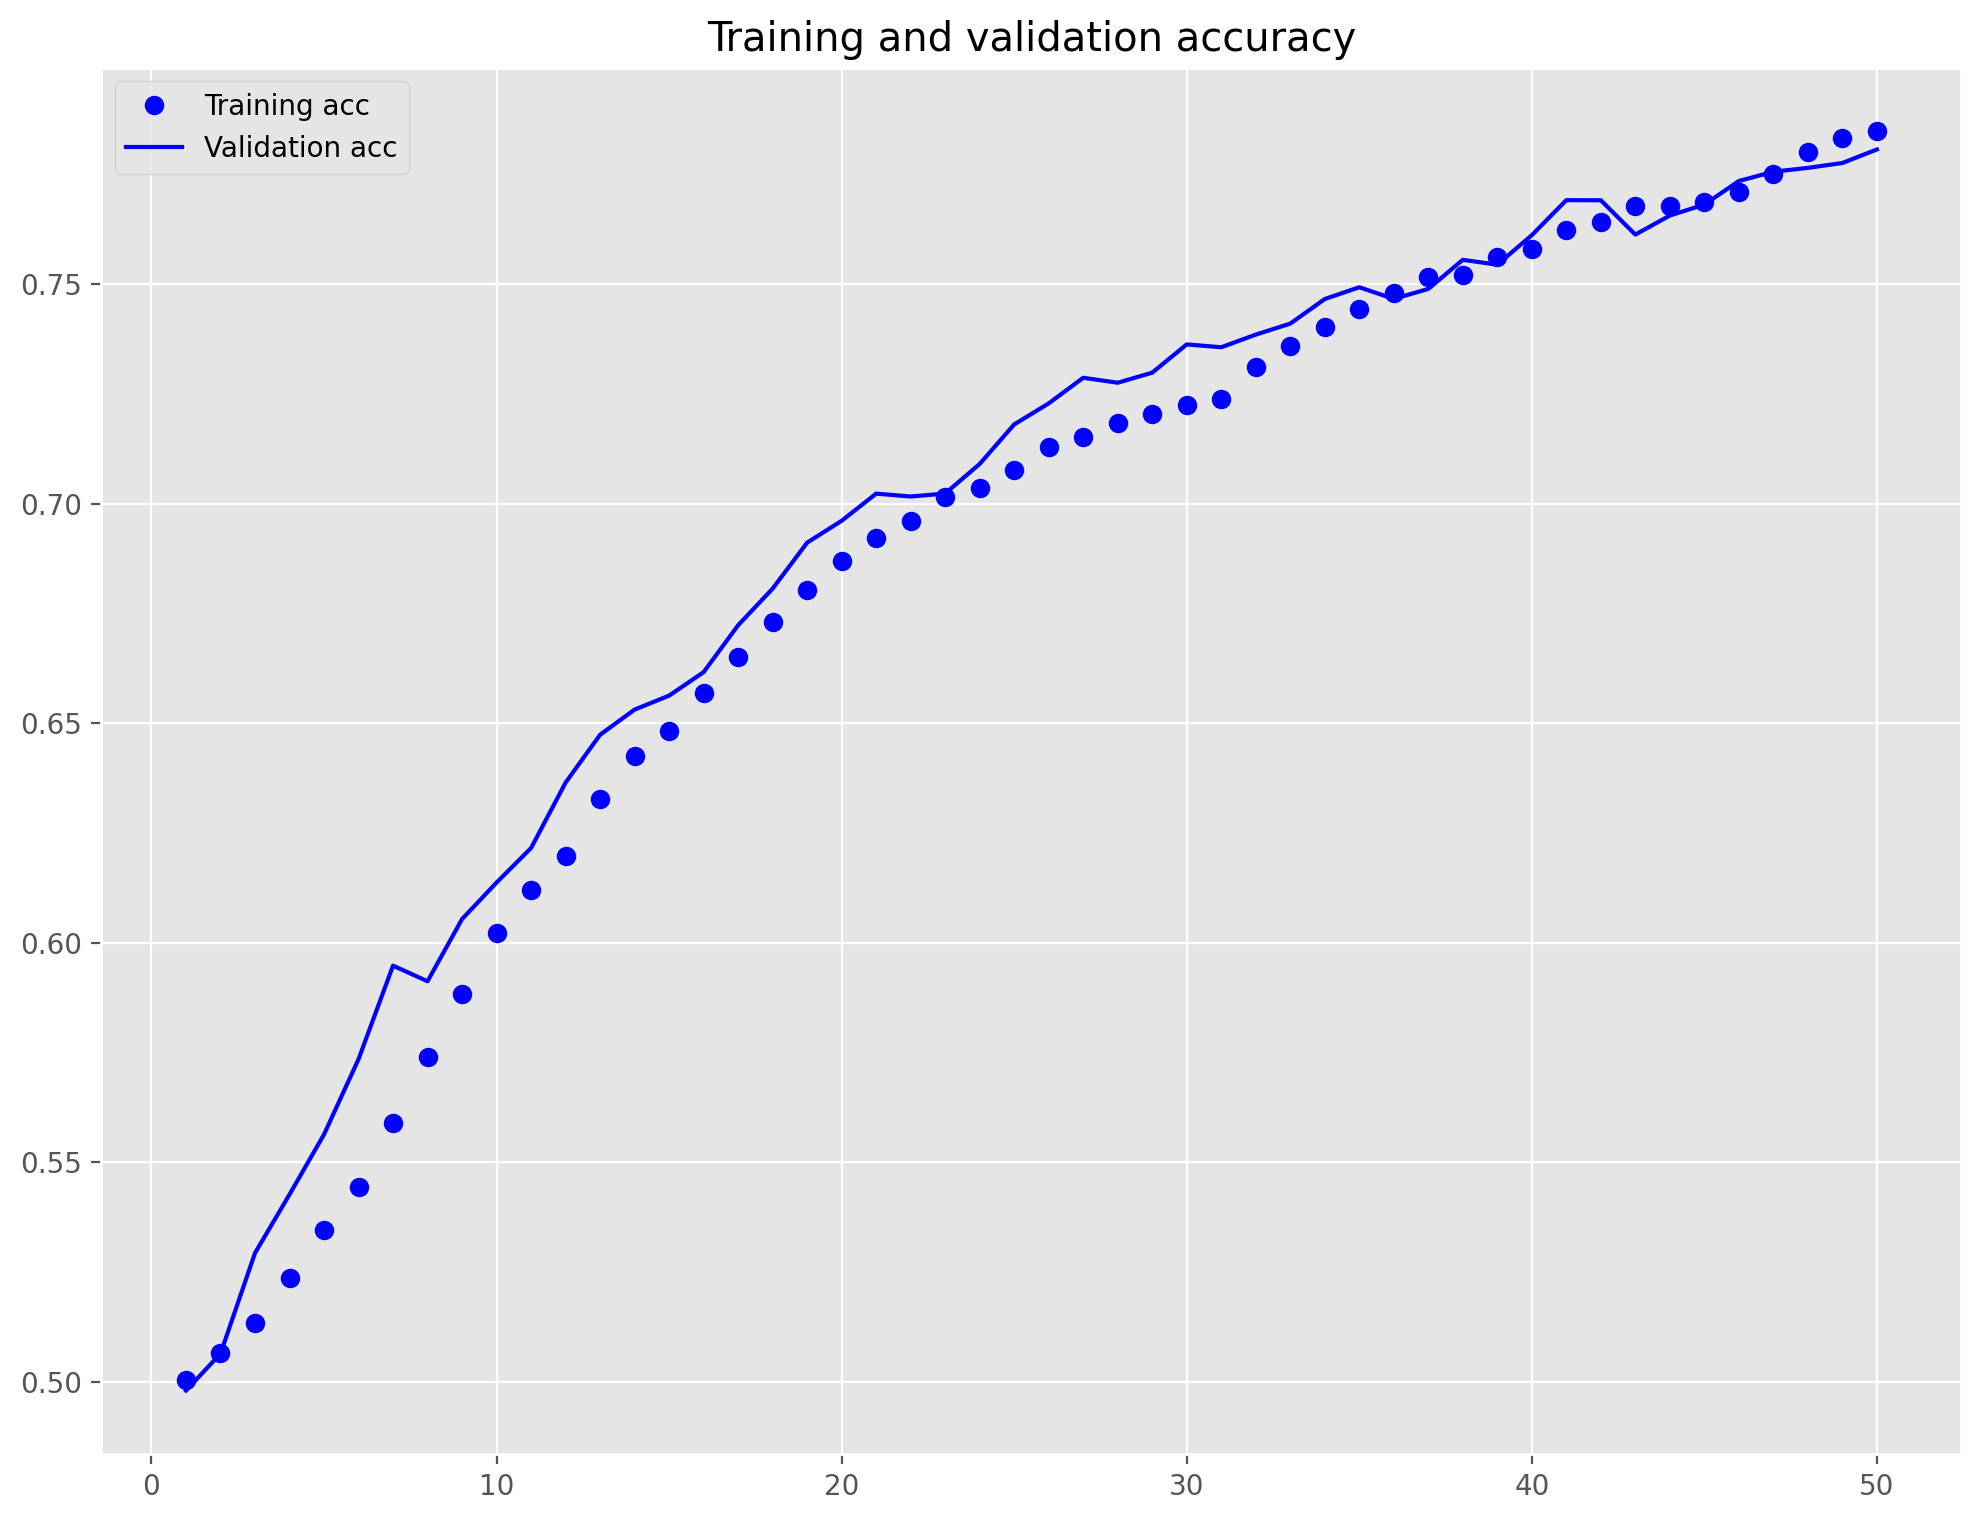

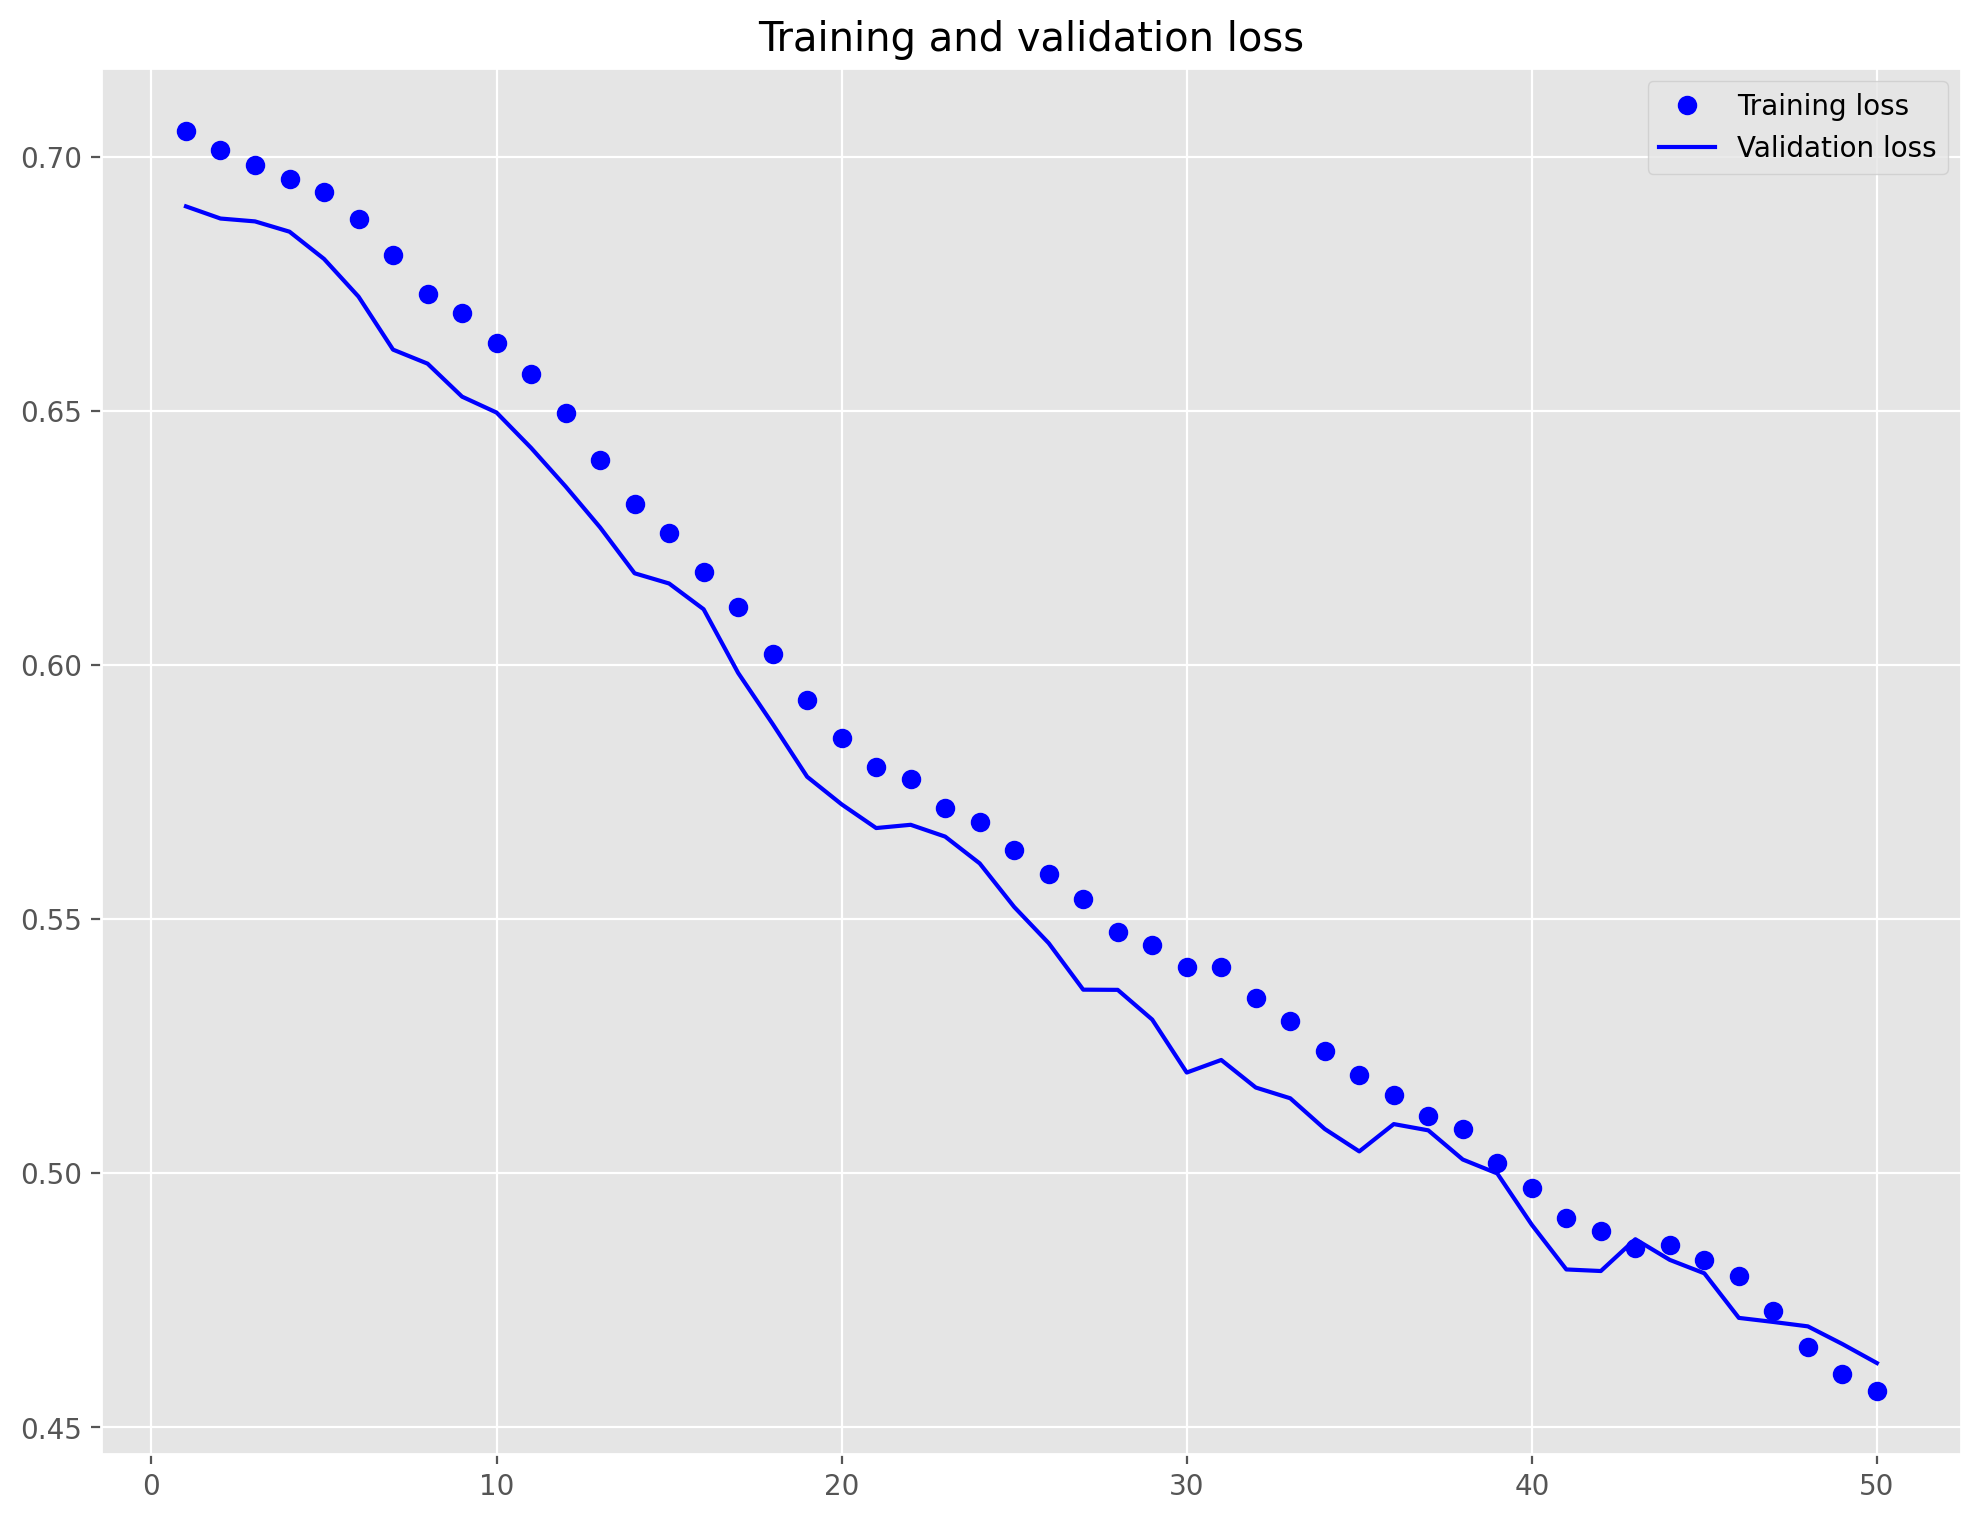

In [ ]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug, steps=50)

# Visualización de mapas de caracteristicas

In [ ]:
import os

# Ruta al directorio de gatos
img_dir = '/content/dataset/cats_and_dogs_small/train/cats'

# Listar imágenes en el directorio
img_files = os.listdir(img_dir)
print(img_files)  # Esto nos mostrará los nombres de los archivos de imagen


['cat.818.jpg', 'cat.762.jpg', 'cat.938.jpg', 'cat.75.jpg', 'cat.0.jpg', 'cat.402.jpg', 'cat.372.jpg', 'cat.370.jpg', 'cat.894.jpg', 'cat.951.jpg', 'cat.152.jpg', 'cat.816.jpg', 'cat.390.jpg', 'cat.548.jpg', 'cat.284.jpg', 'cat.224.jpg', 'cat.795.jpg', 'cat.994.jpg', 'cat.196.jpg', 'cat.110.jpg', 'cat.38.jpg', 'cat.815.jpg', 'cat.465.jpg', 'cat.40.jpg', 'cat.135.jpg', 'cat.656.jpg', 'cat.73.jpg', 'cat.161.jpg', 'cat.277.jpg', 'cat.967.jpg', 'cat.363.jpg', 'cat.661.jpg', 'cat.464.jpg', 'cat.303.jpg', 'cat.375.jpg', 'cat.798.jpg', 'cat.185.jpg', 'cat.457.jpg', 'cat.563.jpg', 'cat.711.jpg', 'cat.521.jpg', 'cat.329.jpg', 'cat.974.jpg', 'cat.844.jpg', 'cat.56.jpg', 'cat.111.jpg', 'cat.274.jpg', 'cat.863.jpg', 'cat.176.jpg', 'cat.593.jpg', 'cat.928.jpg', 'cat.850.jpg', 'cat.207.jpg', 'cat.547.jpg', 'cat.876.jpg', 'cat.636.jpg', 'cat.10.jpg', 'cat.235.jpg', 'cat.308.jpg', 'cat.339.jpg', 'cat.226.jpg', 'cat.570.jpg', 'cat.202.jpg', 'cat.764.jpg', 'cat.86.jpg', 'cat.397.jpg', 'cat.71.jpg', 'cat

In [ ]:
from keras.preprocessing import image
import numpy as np

img_name = img_files[0]  # seleccion del primer archivo
img_path = os.path.join(img_dir, img_name)  # ruta del directorio con el nombre del archivo

# Cargar la imagen
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)


(1, 150, 150, 3)


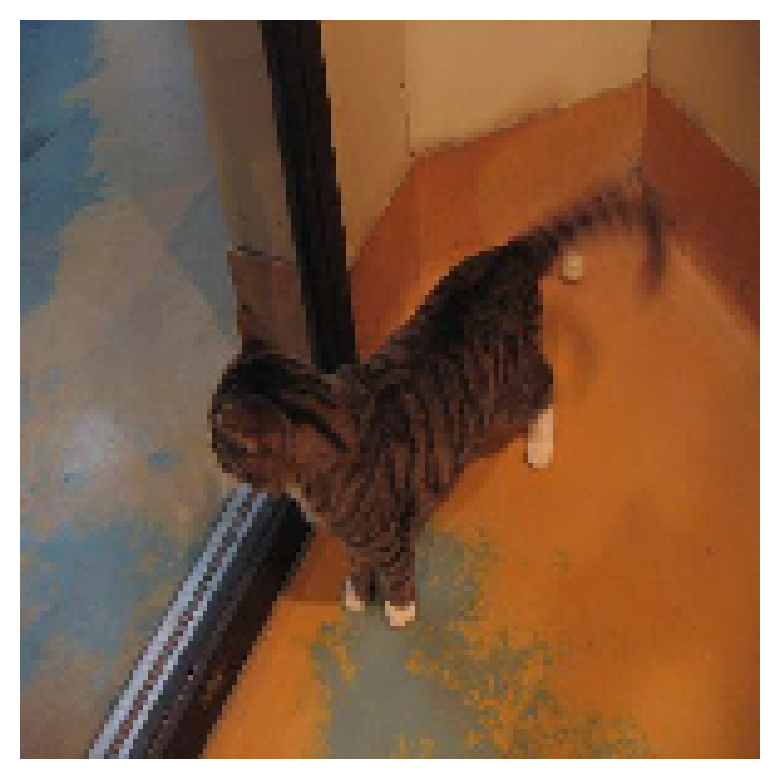

In [ ]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


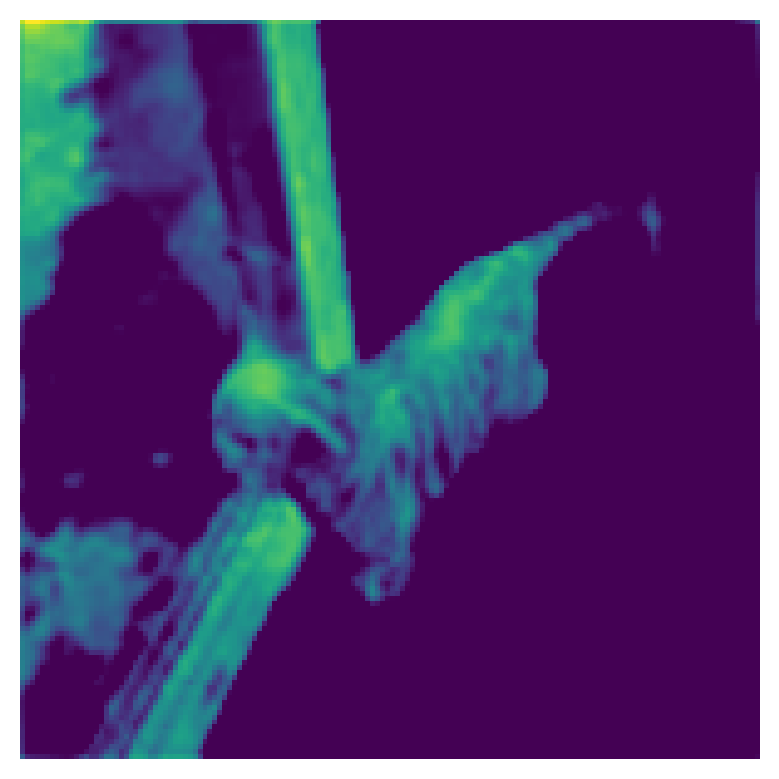

In [ ]:
# Extracción de las salidas de las 8 capas superiores:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


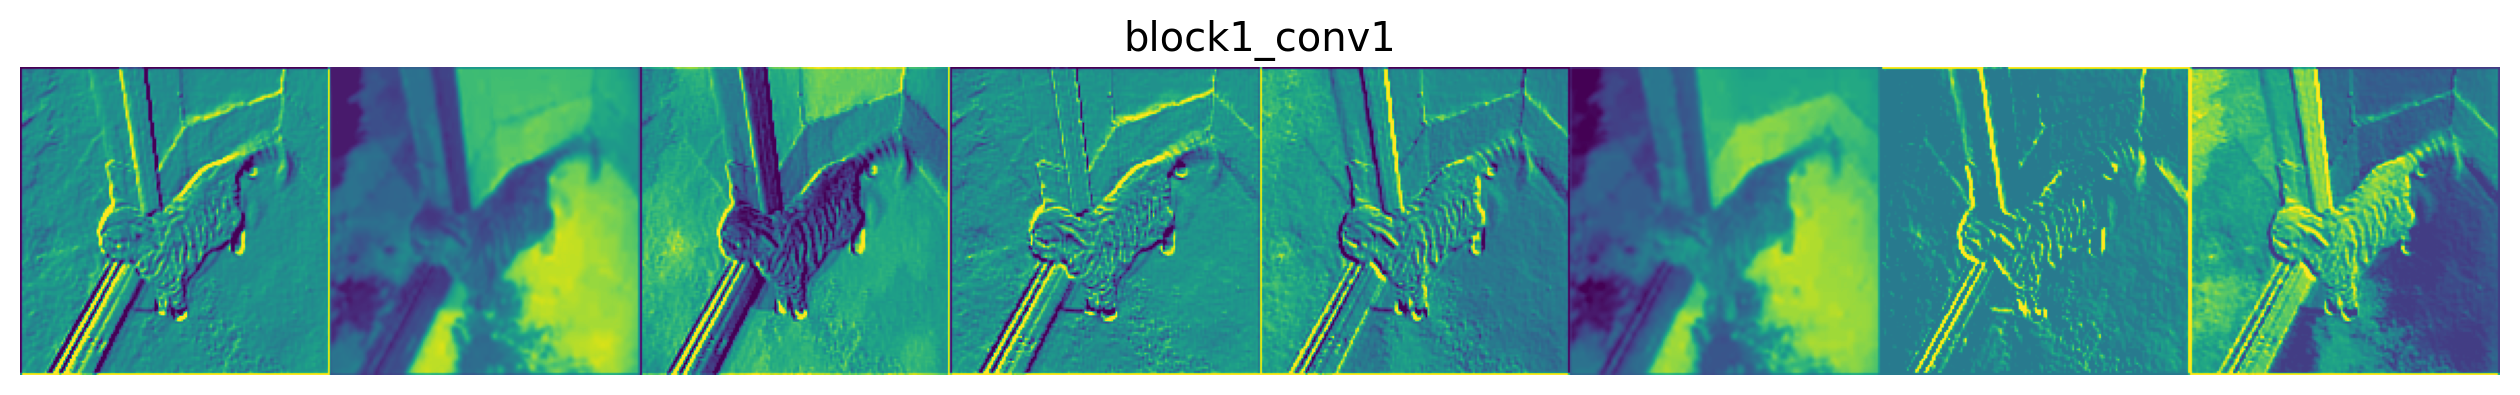

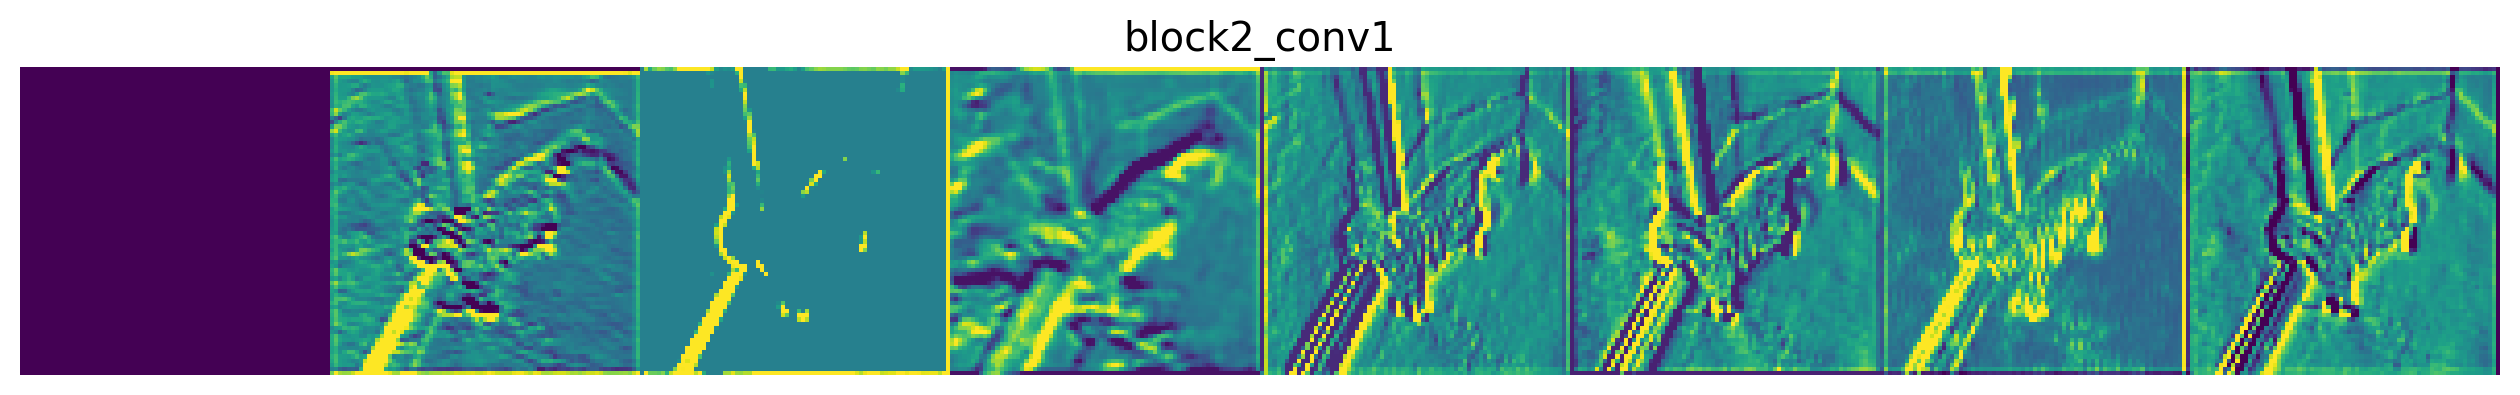

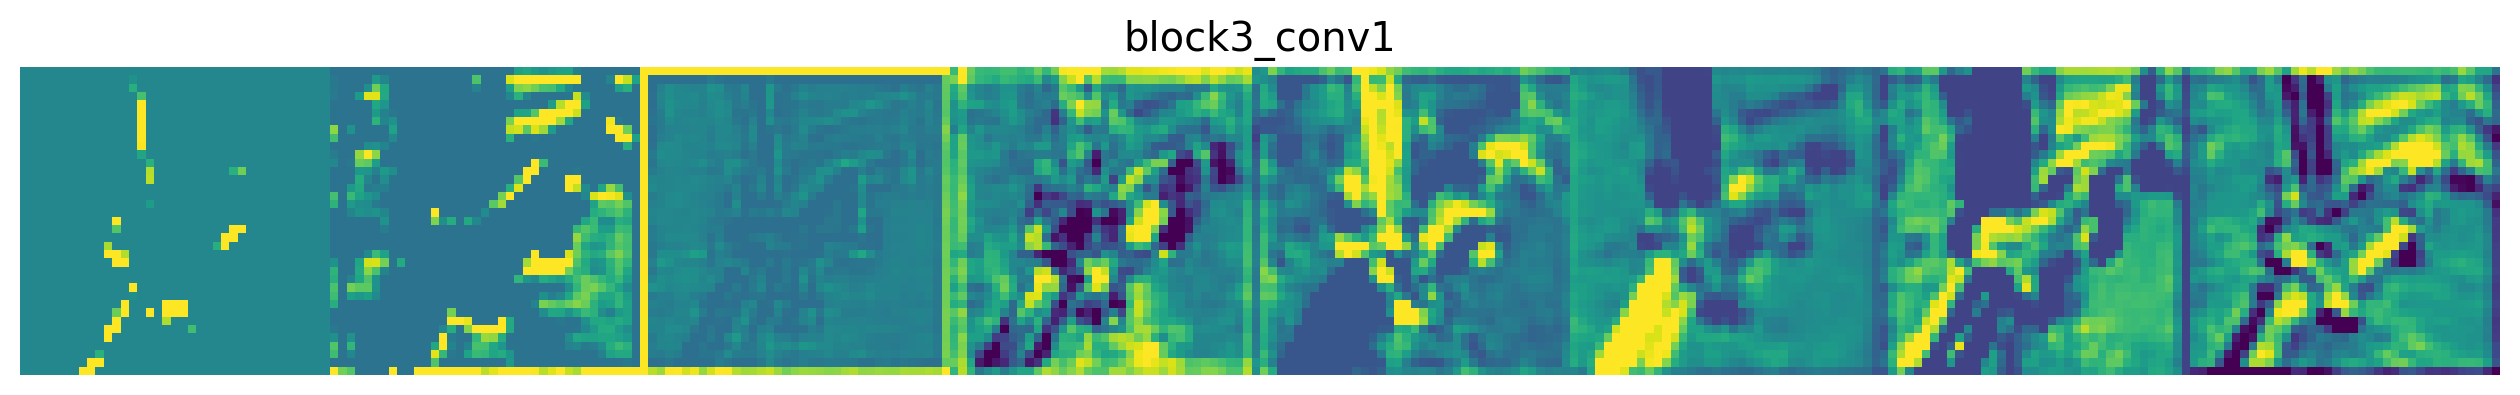

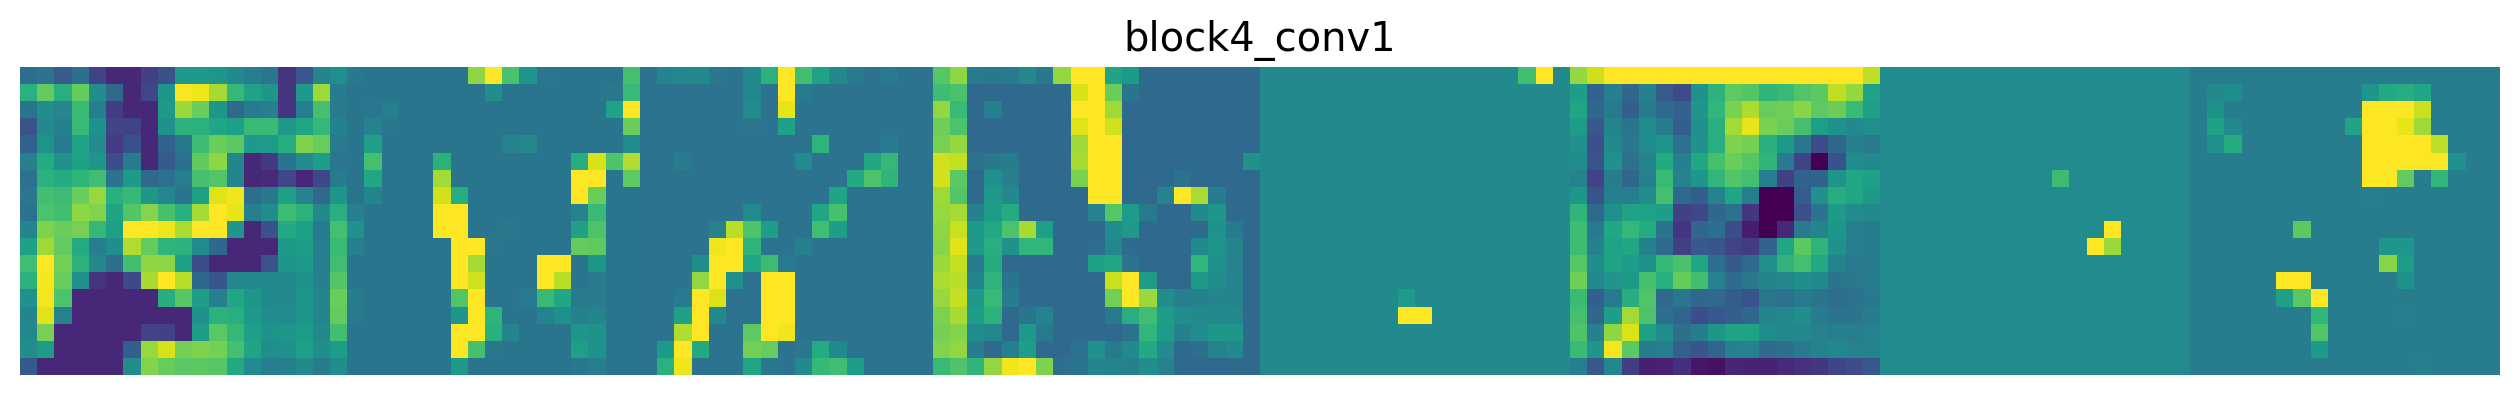

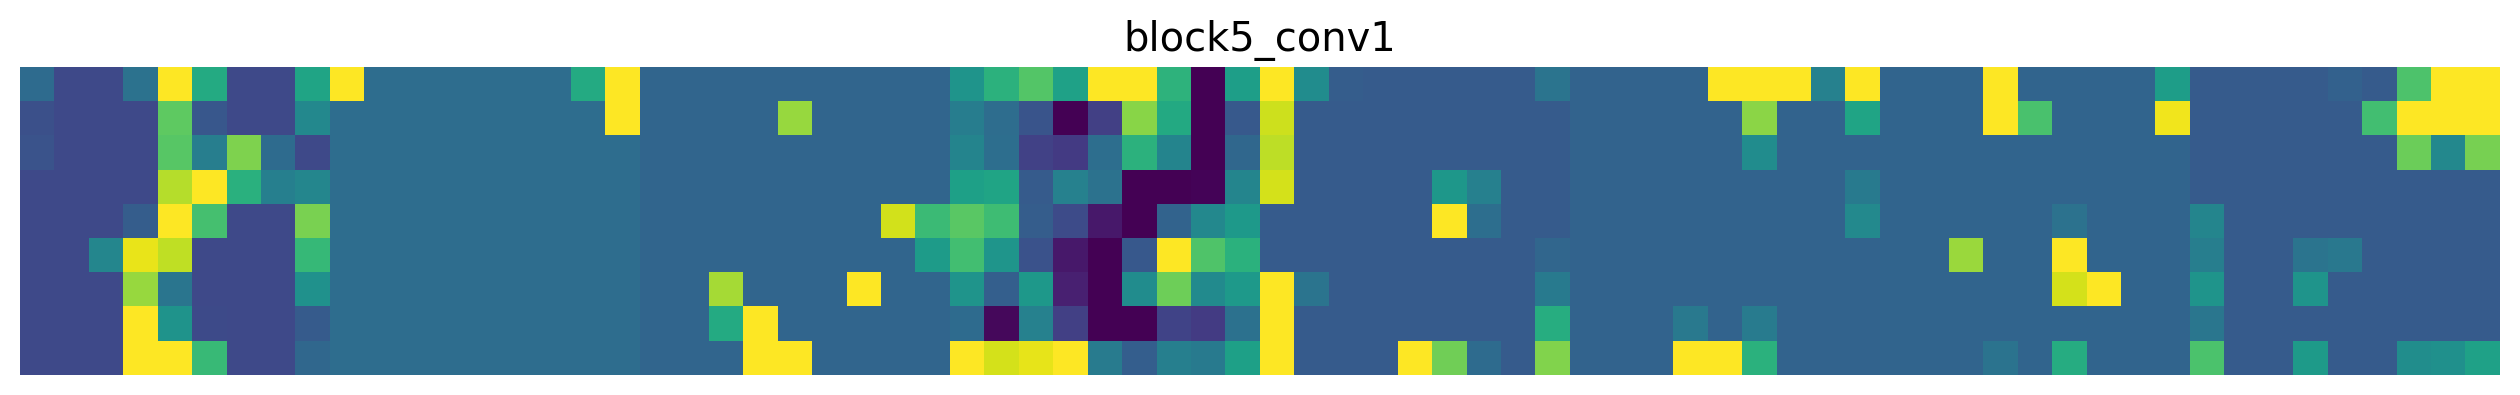

In [ ]:
# Nombres de las capas que queremos visualizar
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Obtener las salidas de las capas especificadas
layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]

# Crear un modelo que toma la entrada de VGG y devuelve las salidas de las capas seleccionadas
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)

# Predecir las activaciones intermedias usando el modelo creado
intermediate_activations = activation_model.predict(img_tensor)

# Configuración para mostrar las imágenes
images_per_row = 8  # Número de imágenes por fila
max_images = 8      # Máximo de imágenes a mostrar

# Ahora vamos a mostrar nuestros mapas de características
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # Este es el número de características en el mapa de características
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)  # Limitar el número de características a mostrar

    # El mapa de características tiene forma (1, tamaño, tamaño, n_features)
    size = layer_activation.shape[1]

    # Vamos a organizar los canales de activación en esta matriz
    n_cols = n_features // images_per_row  # Número de columnas
    display_grid = np.zeros((size * n_cols, images_per_row * size))  # Matriz para mostrar las imágenes

    # Vamos a colocar cada filtro en esta gran cuadrícula horizontal
    for col in range(n_cols):
        for row in range(images_per_row):
            # Obtener la imagen del canal correspondiente
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Procesar la característica para hacerla visualmente más agradable
            channel_image -= channel_image.mean()  # Centrar la imagen
            channel_image /= channel_image.std()    # Normalizar la imagen
            channel_image *= 64                     # Escalar la imagen
            channel_image += 128                    # Desplazar la imagen
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')  # Limitar los valores entre 0 y 255

            # Colocar la imagen del canal en la cuadrícula de visualización
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Mostrar la cuadrícula
    scale = 2. / size  # Escalar el tamaño de la figura
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))  # Crear la figura
    plt.axis('off')  # No mostrar ejes
    plt.title(layer_name)  # Título de la capa
    plt.grid(False)  # Sin cuadrícula
    plt.imshow(display_grid, aspect='auto', cmap='viridis')  # Mostrar la cuadrícula de activaciones

plt.show()  # Mostrar todas las figuras
